In [1]:
# Imports
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import ipywidgets as ipw
import base64
from random import randint

In [2]:
# Use the RFSoC overlay
from pynq.overlays.base import BaseOverlay
#from rfsoc_radio.overlay import RadioOverlay
from pynq import Clocks
import xrfdc
import os
base = BaseOverlay('base.bit')
#ol = RadioOverlay(run_test=False, debug_test=False)

# this_dir = os.path.dirname(__file__)
# bitfile_name = os.path.join(this_dir, 'rfsoc_radio', 'bitstream', 'rfsoc_radio.bit')

# help(ol.radio_receiver)

# Start RF clocks
# help(Clocks)
# help(base)



# Channels
#print("Transmitter channels:\n",base.radio.transmitter.get_channel_description())
DAC_CHANNEL_B = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
DAC_CHANNEL_A = 1 # 'Channel 1': {'Tile': 230, 'Block': 0}

#print("Receiver channels:\n",base.radio.receiver.get_channel_description())
ADC_CHANNEL_D = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
ADC_CHANNEL_C = 1 # 'Channel 1': {'Tile': 224, 'Block': 1}
ADC_CHANNEL_B = 2 # 'Channel 2': {'Tile': 226, 'Block': 0}
ADC_CHANNEL_A = 3 # 'Channel 3': {'Tile': 226, 'Block': 1}

In [3]:

# Generate message
def _create_buffer(data=np.array([72, 101, 108, 108, 111,  32,  87, 111, 114, 108, 100,  33], dtype=np.uint8), eof=1, padding=0):
        """Create a buffer that is loaded user data. Append the Extended Barker sequence
        to the user data and then pad with zeros
        """
        frame_number = 0
        random_size = 10
        flags = eof
        if data.size == 0:
            raise ValueError('Message size should be greater than 0.')
        msg = np.array(data, dtype=np.uint8)
        # Append Barker and Random Data
        bkr = np.array([0, 0, 63, 112, 28, len(msg) + 5, frame_number, flags, 5, len(msg), padding], dtype=np.uint8)
        rnd = np.array([randint(0, 255) for p in range(0, random_size)], dtype=np.uint8)
        seq = np.append(bkr, msg)
        seq = np.append(rnd, seq)
        pad = np.append(seq, np.zeros(int(np.ceil((len(rnd) + len(bkr) + len(msg))/32) * 32 - (len(rnd) + len(bkr) + len(msg))), dtype=np.uint8))
        buf = allocate(shape=(len(pad),), dtype=np.uint8)
        buf[:] = pad[:]
        return buf

In [4]:
from pynq import allocate
expected_message = _create_buffer()
print("expected_message: ", expected_message)

expected_message:  [ 80 132   9 147 241 228  34 147  92  11   0   0  63 112  28  17   0   1
   5  12   0  72 101 108 108 111  32  87 111 114 108 100  33   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [5]:
# Set the center frequency and sampling frequency
center_frequency = 1240e6  # Hz Frequency of incoming signal
sample_frequency = 2457.6e6  # Hz I believe the default sample frequency is 2457.6e6 Hz which is sufficient for our signal
downsample_factor = 2  # Choose how much to decimate by i.e '2' decimates 2x
number_samples = 32768  # Between 16 and 32768

# Set mixer frequency to center frequency to demodulate carrier frequency
base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings['Freq'] = 1240 # MHz
base.radio.receiver.channel[ADC_CHANNEL_C].adc_block.MixerSettings['Freq'] = 1240 # MHz
base.radio.receiver.channel[ADC_CHANNEL_B].adc_block.MixerSettings['Freq'] = 1240 # MHz
base.radio.receiver.channel[ADC_CHANNEL_A].adc_block.MixerSettings['Freq'] = 1240 # MHz



In [6]:
# Function to plot real and imaginary data in time domain
def plot_complex_time(data, n, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_re_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data), name='Real'))
    plt_im_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.imag(data), name='Imag'))
    return go.FigureWidget(data = [plt_re_temp, plt_im_temp],
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})

def plot_time(data, n, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = data))
    return go.FigureWidget(data = plt_temp,
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})

# Functions
# Function to convert integer to binary array
def int_to_binary_array(num, num_bits):
    return np.array(list(format(num, f'0{num_bits}b')), dtype=int)

# Function to convert binary array to integer
def binary_array_to_int(binary_array):
    return int(''.join(map(str, binary_array)), 2)

In [7]:
# Sample
real_raw_data = []  # Storage for incoming I and Q data
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    real_raw_data.append(base.radio.receiver.channel[i].transfer(number_samples))
#print(raw_data[ADC_CHANNEL_D])
#print("raw_data: ", raw_data[ADC_CHANNEL_D])
#print("number_samples: ", number_samples)

# Plotting raw data in the time domain
figs = [] # Storage for ADC time domain plots

# Add plots to figs
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_complex_time(
        data=real_raw_data[i], 
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel ', str(i), ' Before Downconversion'])))
    
# plot ADC real and imaginary time domain data
ipw.VBox(figs)

# THESE SHOULD LOOK LIKE THE MODULATED WAVES

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

In [8]:
from rfsystem.spectrum_sweep import SpectrumAnalyser

analysers = []
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    analysers.append(
        SpectrumAnalyser(channel = base.radio.receiver.channel[i],
                         sample_frequency = sample_frequency,
                         number_samples = number_samples,
                         title = ''.join(['Spectrum Analyser Channel ',
                                          str(i)]),
                         height = None,
                         width = None))

ipw.VBox([analyser.spectrum_plot.get_plot() for analyser in analysers])

    'data': [{'name': 'Spectrum',
              'type': 'scatter',
             …

In [9]:
import time

for i in range(0, 20):
    for analyser in analysers:
        analyser.update_spectrum()
    time.sleep(0.2)

In [10]:
# base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings['MixerMode'] = 3 # 3 is default (real to complex), 1 does something, nothing else valid
# base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings['MixerType'] = 1 # With the carrier we want fine(2). w/o we want coarse (1) 2 is default, 1 is coarse?
# base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings['PhaseOffset'] = 0.0 # Use if result is noisy or slightly off

base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings = {
    'CoarseMixFreq':  xrfdc.COARSE_MIX_SAMPLE_FREQ_BY_FOUR,
    'EventSource':    xrfdc.EVNT_SRC_TILE, 
    'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
    'Freq':           0.0,
    'MixerMode':      xrfdc.MIXER_MODE_R2C,
    'MixerType':      xrfdc.MIXER_TYPE_COARSE,
    'PhaseOffset':    0.0
}
#print(base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings)
#print(base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.NyquistZone)
#base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

In [11]:
# View configurable settings of ADCs
print("ADC MixerSettings: ", base.radio.receiver.channel[0].adc_block.MixerSettings.keys())
#help(base.radio.receiver.channel[0].adc_tile)
#help(base.radio.receiver.channel[0].adc_block)
print("ADC MixerSettings: ", base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings)
# print(xrfdc.MIXER_MODE_R2C)
# print(xrfdc.MIXER_TYPE_COARSE)
# print(xrfdc.MIXER_TYPE_FINE)
# print(xrfdc.RFdcAdcBlock.DecimationFactor)
# print(xrfdc.RFdcAdcTile.PLLConfig)
# print(xrfdc.RFdcAdcTile.ClockSource)
# print(xrfdc.RFdc.read(base.radio/rfdc))

ADC MixerSettings:  dict_keys(['Freq', 'PhaseOffset', 'EventSource', 'CoarseMixFreq', 'MixerMode', 'FineMixerScale', 'MixerType'])
ADC MixerSettings:  {'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 4, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 1}


In [12]:
# Sample
raw_data = []  # Storage for incoming I and Q data
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    raw_data.append(base.radio.receiver.channel[i].transfer(number_samples))
#print(raw_data[ADC_CHANNEL_D])
#print("raw_data: ", raw_data[ADC_CHANNEL_D])
#print("number_samples: ", number_samples)

In [14]:
# Plotting raw data in the time domain
figs = [] # Storage for ADC time domain plots

# Add plots to figs
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_complex_time(
        data=raw_data[i], 
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel ', str(i), ' Before Downconversion'])))
    
# plot ADC real and imaginary time domain data
ipw.VBox(figs)

# THESE SHOULD LOOK LIKE THE MODULATED WAVES

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

In [15]:
from rfsystem.spectrum_sweep import SpectrumAnalyser

analysers = []
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    analysers.append(
        SpectrumAnalyser(channel = base.radio.receiver.channel[i],
                         sample_frequency = sample_frequency,
                         number_samples = number_samples,
                         title = ''.join(['Spectrum Analyser Channel ',
                                          str(i)]),
                         height = None,
                         width = None))

ipw.VBox([analyser.spectrum_plot.get_plot() for analyser in analysers])


    'data': [{'name': 'Spectrum',
              'type': 'scatter',
             …

In [16]:
import time

for i in range(0, 20):
    for analyser in analysers:
        analyser.update_spectrum()
    time.sleep(0.2)

In [18]:
# Downconvert
downconverted_data = []  # Storage for downconverted data
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    downconverted_data.append(signal.decimate(raw_data[i], downsample_factor))
number_samples = int(number_samples / downsample_factor) # Updating number of samples
sample_frequency = sample_frequency/downsample_factor # Downsampled signal has new step_size, this will result in accurate plotting of the data

# print("downconverted_data: ",downconverted_data[ADC_CHANNEL_D])
# print("number_samples: ", number_samples)

In [19]:
# Plotting downconverted data in the time domain
figs = [] # Storage for ADC time domain plots

#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_complex_time(
        data=downconverted_data[i],
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel ', str(i), ' After Downconversion'])))
    
# plot ADC real and imaginary time domain data
ipw.VBox(figs) # Only show ADC D 

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

In [20]:
# Parameters - NEED TO CHECK ON ALL OF THESE, HOW DO WE MATCH TO OUR BASEBAND SIGNAL?
# bit rate 
# HackRF parameters: Sample Rate = 4 MHz, Symbol Rate = 1 MHz, Interpolation = 2 MHz, Decimation/Sample Rate = 48 kHz
br = 50000  # Is this set to sample_frequency? 

# carrier frequency
f = br      # Is this set to center_frequency?
# bit duration
T = 1/br    # What is this?


In [21]:
# PREVIOUS "WORKING" IMPLEMENTATION

# Demodulate using in phase and quadrature data from ADC D
Rx_data = np.array([])
Rx_in_data = np.array([])
Rx_qd_data = np.array([])
Z_in = np.array([])
Z_qd = np.array([])



for i in range(len(downconverted_data[ADC_CHANNEL_D])//2):
    # Inphase coherent detector
    Z_in = np.append(Z_in, downconverted_data[ADC_CHANNEL_D].real[i*99:(i+1)*99])
    Z_in_intg = np.trapz(Z_in) * (2 / T) # Finding average value?
    #print(Z_in_intg)
    if Z_in_intg > 0:
        Rx_in_data = np.append(Rx_in_data, 1)
    else:
        Rx_in_data = np.append(Rx_in_data, 0)

    # Quadrature coherent detector
    Z_qd = np.append(Z_qd, downconverted_data[ADC_CHANNEL_D].imag[i*99:(i+1)*99])
    Z_qd_intg = np.trapz(Z_qd) * (2 / T) # Finding average value?
    #print(Z_qd_intg)
    if Z_qd_intg > 0:
        Rx_qd_data = np.append(Rx_qd_data, 1)
    else:
        Rx_qd_data = np.append(Rx_qd_data, 0)
    Rx_data = np.append(Rx_data, [Rx_in_data[i], Rx_qd_data[i]])

#print("Z_in: ", Z_in)
# print("Z_qd: ", Z_qd)
# print("length of Z_in: ", len(Z_in))
# print("Rx_in_data: ", Rx_in_data)
# print("length of Z_qd: ", len(Z_qd))
# print("Rx_qd_data: ", Rx_qd_data)
# print("length of Rx_data: ", len(Rx_data))
# print("Rx_data: ", Rx_data)


In [22]:
# Try to plot received In phase and Quadrature Data
figs = [] # Storage for ADC time domain plots

#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_time(
        data=Z_in,
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel In Phase Data ', str(i)])))
    
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_time(
        data=Z_qd,
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel Quadrature Data ', str(i)])))
    
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_time(
        data=Z_in+Z_qd,
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel Sum of Z_in and Z_qd ', str(i)])))
    
# Show plots
ipw.VBox(figs)

    'data': [{'type': 'scatter',
              'uid': 'e8131104-477a-48bc-9e94-8…

In [23]:
# Plotting received data
# tt = np.arange(0, T*(len(Z_in)/2), T/99)

# plt.figure(figsize=(10, 8))

# Calculate magnitude of downconverted_data
# incoming_modulated_signal = []
# i = 0
# while i < len(downconverted_data[ADC_CHANNEL_D]):
#     incoming_modulated_signal.append(np.sqrt((downconverted_data[ADC_CHANNEL_D][i].real**2)+(downconverted_data[ADC_CHANNEL_D][i].imag**2)))
#     i += 2


# Modulated signal at baseband premodulation
# plt.subplot(3, 1, 1)
# plt.plot(tt, incoming_modulated_signal, 'r', linewidth=3)
# plt.grid(True)
# plt.title('QPSK modulated signal (sum of inphase and quadrature phase signal)')
# plt.xlabel('Time (sec)')
# plt.ylabel('Amplitude (volt)')

# In Phase Data
# plt.subplot(3, 1, 2)
# plt.plot(tt, Z_in, linewidth=3)
# plt.grid(True)
# plt.title('Waveform for In phase component in QPSK modulation')
# plt.xlabel('Time (sec)')
# plt.ylabel('Amplitude (volt)')

# Quadrature Data
# plt.subplot(3, 1, 3)
# plt.plot(tt, Z_qd, linewidth=3)
# plt.grid(True)
# plt.title('Waveform for Quadrature component in QPSK modulation')
# plt.xlabel('Time (sec)')
# plt.ylabel('Amplitude (volt)')

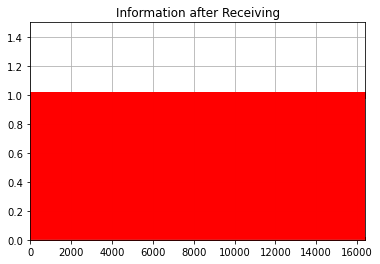

Received binary:  [1. 0. 1. ... 0. 1. 0.]
actual_word:  [1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
Bit Error Rate: 51.35135135135135%
Received integer:  32948629785450476153064626079625015843581846562193538431
rec_bytes_representation:  b'\x01W\xff\xefW\xfe\xad\x7f\xff\xff\xf5\xff\xebU\xff\xebU\xff\xad_\xff\xff\xfd\x7f'


In [29]:
# Plot binary
plt.figure()
plt.stem(range(len(Rx_data)), Rx_data, linefmt='r-', markerfmt='ro')
plt.title('Information after Receiving')
plt.axis([-.5, len(Rx_data) + .5, 0, 1.5])
plt.grid(True)
plt.show()

print("Received binary: ", Rx_data)
number_bytes = 23
original_message_length = number_bytes*8
actual_word = np.array([])
for i in range(0, original_message_length+1):
    actual_word = np.append(actual_word, Rx_data[i])
print("actual_word: ", actual_word)
expected_word = '011010000110010101101100011011000110111100100000011001110111001001101111011011110111011001101001011011100110011100100000011100110110100001110010011001010110010001100100011001010111001001110011'
test_actual = ''

for i in actual_word:
    test_actual += str(int(i))

wrong = 0
for i in range(0, len(test_actual)):
    if test_actual[i] != expected_word[i]:
        wrong += 1
    
bit_error_rate = 100 * (wrong / len(test_actual))
print("Bit Error Rate: " + str(bit_error_rate) + "%")

# Actual Message:
# 01101000 01100101 01101100 01101100 01101111 00100000 01100111 01110010 01101111 01101111 01110110 01101001 01101110 01100111 00100000 01110011 01101000 01110010 01100101 01100100 01100100 01100101 01110010 01110011
# Received:
# 01010100 00011100 00011100 01010100 01011100 01011100 01011000 
# 01111101 01111000 01111001 01111001 01110001 11111001 11110001
# 11110001 11110101 11100001 11100111 11110111 11100111 11011111
# 11001111 0101111

# Expected
# Convert binary to integer
received_integer = binary_array_to_int(actual_word.astype(int))
print("Received integer: ", received_integer)

# Convert integer to bytes
rec_bytes_representation = received_integer.to_bytes((received_integer.bit_length() + 7) // 8, byteorder='big')
print("rec_bytes_representation: ", rec_bytes_representation)

# Decode bytes back to string NOT WORKING
# decoded_string = rec_bytes_representation.decode('ascii') # WHAT ENCODING SCHEME DID WE USE?
# print("Received Word: ", decoded_string)

# # Convert binary to integer
# received_integer = binary_array_to_int(Rx_data.astype(int))
# print("Received integer: ", received_integer)

# # Convert integer to bytes
# rec_bytes_representation = received_integer.to_bytes((received_integer.bit_length() + 7) // 8, byteorder='big')
# print("rec_bytes_representation: ", rec_bytes_representation)

# # Decode bytes back to string
# decoded_string = rec_bytes_representation.decode('ascii') # WHAT ENCODING SCHEME DID WE USE?
# print("Received Word: ", decoded_string)


In [18]:
window = np.array(np.blackman(number_samples)[:])
# print("window:", window)
# print("cdata:", cdata[0])

# downsample_window = np.array(np.blackman(number_samples/downsample_factor)[:])
# print("window:", window)
# print("cdata:", cdata[0])

wdata = []
wfigs = []
wdata.append(cdata[0]*window)
# print("wdata:", wdata[0])
# wfigs.append(plot_complex_time(
#         data=wdata[0], 
#         title=''.join(['Windowed Plot of ADC Channel ', str(2), ' Before Downconversion'])))

# wdata.append(downsampled_signal*downsample_window)
# wfigs.append(plot_complex_time(
#         data=wdata[1], 
#         title=''.join(['Windowed Plot of ADC Channel ', str(2), ' After Downconversion'])))

# ipw.VBox(wfigs)

NameError: name 'cdata' is not defined

In [ ]:
fdata = []
for i in range(0, len(wdata)):
    fdata.append(np.fft.fftshift(np.fft.fft(wdata[i])))

In [ ]:
def plot_complex_spectrum(data, N=number_samples, fs=sample_frequency, 
                          title='Complex Spectrum Plot', units='dBW', fc=0):
    plt_temp = (go.Scatter(x = np.arange(-fs/2, fs/2, fs/N) + fc,
                           y = data, name='Spectrum'))
    return go.FigureWidget(data = plt_temp,
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Frequency (Hz)',
                                         'autorange': True},
                                     'yaxis': {
                                         'title': units}})

magfigs = []
for i in range(0, len(fdata)):
    magfigs.append(plot_complex_spectrum(
            data=abs(fdata[i]),
            title=''.join(['Frequency Magnitude Plot of ADC Channel ', str(i)]),
            units='|Y(f)|',
            fc=round(abs(base.radio.receiver.channel[i].adc_block.MixerSettings['Freq']))*1e6))

ipw.VBox(magfigs)